<a href="https://colab.research.google.com/github/MishterBluesky/CoEVFold/blob/main/Simple_GREMLIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Simple GREMLIN 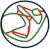

This notebook, derived from MMSEQ2 and GREMLIN finds co-evolutionary interactions based on the input sequence.

It will list the top intramolecular (if only one protein given) or intermolecular (if more than one protein is given) coevolution scores, as well as providing a 2D coevolution contact map.

In [ ]:
%%time
#@title setup
unified_memory = True #@param {type:"boolean"}
import os, time, gc
if unified_memory:
  ENV = {"TF_FORCE_UNIFIED_MEMORY":"1", "XLA_PYTHON_CLIENT_MEM_FRACTION":"4.0"}
  for k,v in ENV.items(): os.environ[k] = v
if not os.path.isdir("params"):
  # get code
  print("installing ColabDesign")
  os.system("(mkdir params; apt-get install aria2 -qq; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; touch params/done.txt )&")

  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@gamma")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")
  os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/main/colabfold/colabfold.py -O colabfold_utils.py")
  #os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/beta/colabfold/mmseqs/api.py")

  # install hhsuite
  print("installing HHsuite")
  os.makedirs("hhsuite", exist_ok=True)
  os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C hhsuite/")

  # download params
  if not os.path.isfile("params/done.txt"):
    print("downloading AlphaFold params")
    while not os.path.isfile("params/done.txt"):
      time.sleep(5)
if "hhsuite" not in os.environ['PATH']:
  os.environ['PATH'] += ":hhsuite/bin:hhsuite/scripts"

import re, tempfile
from IPython.display import HTML
from google.colab import files
import numpy as np
from colabdesign import mk_af_model, clear_mem
from colabdesign.af.contrib import predict
from colabdesign.af.contrib.cyclic import add_cyclic_offset
from colabdesign.shared.protein import _np_rmsd, _np_kabsch
from colabdesign.shared.plot import plot_pseudo_3D, pymol_cmap


import jax
import jax.numpy as jnp
from colabfold_utils import run_mmseqs2
import matplotlib.pyplot as plt
import string
import numpy as np

def clear_mem():
  backend = jax.lib.xla_bridge.get_backend()
  for buf in backend.live_buffers(): buf.delete()

def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.cif -P tmp/")
    return f"tmp/{pdb_code}.cif"
  else:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v4.pdb -P tmp/")
    return f"tmp/AF-{pdb_code}-F1-model_v4.pdb"

def run_hhalign(query_sequence, target_sequence, query_a3m=None, target_a3m=None):
  with tempfile.NamedTemporaryFile() as tmp_query, \
  tempfile.NamedTemporaryFile() as tmp_target, \
  tempfile.NamedTemporaryFile() as tmp_alignment:
    if query_a3m is None:
      tmp_query.write(f">Q\n{query_sequence}\n".encode())
      tmp_query.flush()
      query_a3m = tmp_query.name
    if target_a3m is None:
      tmp_target.write(f">T\n{target_sequence}\n".encode())
      tmp_target.flush()
      target_a3m = tmp_target.name
    os.system(f"hhalign -hide_cons -i {query_a3m} -t {target_a3m} -o {tmp_alignment.name}")
    X, start_indices = predict.parse_hhalign_output(tmp_alignment.name)
  return X, start_indices

def run_do_not_align(query_sequence, target_sequence, **arg):
  return [query_sequence,target_sequence],[0,0]

def run_hhfilter(input, output, id=90, qid=10):
  os.system(f"hhfilter -id {id} -qid {qid} -i {input} -o {output}")

@jax.jit
def get_coevolution(X):
  '''given one-hot encoded MSA, return contacts'''
  Y = jax.nn.one_hot(X,22)
  N,L,A = Y.shape
  Y_flat = Y.reshape(N,-1)
  # covariance
  c = jnp.cov(Y_flat.T)

  # inverse covariance
  shrink = 4.5/jnp.sqrt(N) * jnp.eye(c.shape[0])
  ic = jnp.linalg.inv(c + shrink)

  # partial correlation coefficient
  ic_diag = jnp.diag(ic)
  pcc = ic / jnp.sqrt(ic_diag[:,None] * ic_diag[None,:])

  raw = jnp.sqrt(jnp.square(pcc.reshape(L,A,L,A)[:,:20,:,:20]).sum((1,3)))
  i = jnp.arange(L)
  raw = raw.at[i,i].set(0)
  # do apc
  ap = raw.sum(0,keepdims=True) * raw.sum(1,keepdims=True) / raw.sum()
  return (raw - ap).at[i,i].set(0)

def plot_3D(aux, Ls, file_name, show=False):
  plt.figure(figsize=(10,5))
  xyz = aux["atom_positions"][:,1]
  xyz = xyz @ _np_kabsch(xyz, xyz, return_v=True, use_jax=False)
  ax = plt.subplot(1,2,1)
  if len(Ls) > 1:
    plt.title("chain")
    c = np.concatenate([[n]*L for n,L in enumerate(Ls)])
    plot_pseudo_3D(xyz=xyz, c=c, cmap=pymol_cmap, cmin=0, cmax=39, Ls=Ls, ax=ax)
  else:
    plt.title("length")
    plot_pseudo_3D(xyz=xyz, Ls=Ls, ax=ax)
  plt.axis(False)
  ax = plt.subplot(1,2,2)
  plt.title("plddt")
  plot_pseudo_3D(xyz=xyz, c=aux["plddt"], cmin=0.5, cmax=0.9, Ls=Ls, ax=ax)
  plt.axis(False)
  plt.savefig(file_name, dpi=200, bbox_inches='tight')
  plt.show() if show else plt.close()

installing ColabDesign
installing HHsuite
downloading AlphaFold params
CPU times: user 1.92 s, sys: 384 ms, total: 2.31 s
Wall time: 1min 52s


jobname PbpBFtsW_ef331
length=[403, 716] copies=1
getting paired MSA


COMPLETE: 100%|██████████| 300/300 [elapsed: 00:03 remaining: 00:00]


parsing msas
gathering info
filtering sequences
selecting final sequences


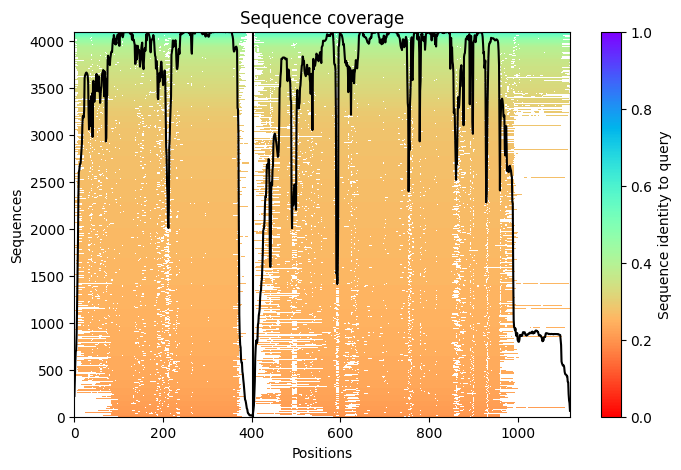

In [ ]:
#@title prep_inputs
sequence = "MLKKMLKSYD YSLIFAIVLL CGFGLVMVYS SSMITAVSRY GVSSNFFFMR QLFALIAGGA LFILMALFPY KALAHQKFQK GILLVSVLAL ISLFVFGHVA GNAQSWFKIG GMSIQPGEFV KLVVILYLAA VYAKKQSYID  HLLTGVAPPV VMTLIICGLI AMQPDFGTAM IIGLIATCMI LCSGFSGKTL VRLVILGGIV FILVSPIIYL NQDKILTEGR LARFESLEDP FKYANSSGLQ VINSYYAISS GGIFGLGLGE SIQKYGYLPE SHTDFIMAVI  AEELGIFGVL FVIFLLGFVV IKGFYIARKC EDPFGSLLAI GISSMIAIQS FINLGGVSGL IPITGVTLPF ISYGGSSLVL LLGSMGILAN ISMFVKYSEN KKKKEPLAPK GMKKKQLKKT VYL:MIQMPKKNKF MNRGAAILSI CFALFFFVIL GRMAYIQITG KANGEVLATK ATEQHEKKRT IEASRGSILD RKGKVIAEDT ATYKLIAILD KKMTTDVKHP QHVVNKEKTA EALSKVINLD KADILDILNK DAKQVEFGSA  GRDITYSQKQ KIEKMKLPGI SFLRDTKRYY PNGVFASNLI GYAEVDEETN EISGAMGLEK VLDKYLKERD GYVTYESDKS GWELPNSKNK ITAPKNGDNV YLTIDQKIQT FLEDSMTKVA QKYNPKKIMA AVVDPKTGKV  LAMGQRPSFD PNKRDVTNYY NDLISYAYEP GSTMKIFTLA AAMQENVFNA NEKYKSGTFE VGGAPVKDHN NGVGWGPTTY HDGVLRSSNV AFAKLAKEKL GYDRLNQYLH KFNFYQKTGI DLPGEVSSKI NFKYEFDKAS  TAYGQASAVT PIQQIQAATA IANDGKMMKP YVIDHIVDPD KDKTIYQNKP ESAGTPISAS TAKKVRDILG EVVTSKIGTG QAYKIEGFDV AGKTGTAQIA GKGGYLDGTD NYIFSFMGMA PKDDPELLIY VAVQQPQLKA  GQSSSDPVSE IFNPTMKNSL HYLNIEPTEK SDSDKEETKA QTMPDLTDQT VAAAQKKAKE ENLTPIVIGS DVAVKEQYPK ADEEVLTNQK VFLKTGGKIK MPDMTGWSRR EVLQYGELAG IHIEVSGQGY AVSQSVKKDK  EIKDKTVIKV KFKNPD" #@param {type:"string"}
jobname = "PbpB-FtsW" #@param {type:"string"}
query_sequence = sequence
copies = 1
#@markdown ----
#@markdown **MSA options**
msa_method = "mmseqs2" #@param ["mmseqs2","single_sequence", "custom_fas", "custom_a3m", "custom_sto"]
pair_mode = "paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown filtering options
cov = 50 #@param ["0", "25", "50", "75", "90", "99"] {type:"raw"}
id = 99 #@param ["90", "95" "100"] {type:"raw"}
qid = 0 #@param ["0", "10", "15", "20", "30"] {type:"raw"}
do_not_filter = False #@param {type:"boolean"}


template_mode = "none"
use_templates = template_mode in ["mmseqs2","custom"]
pdb = ""
chain = "A"
rm_template_seq = False
propagate_to_copies = True
do_not_align = False
rm_sidechain = rm_sequence = rm_template_seq

# filter options
sequence = sequence.upper()
sequence = re.sub("[^A-Z:/()]", "", sequence.upper())
sequence = re.sub("\(",":(", sequence)
sequence = re.sub("\)","):", sequence)
sequence = re.sub(":+",":",sequence)
sequence = re.sub("/+","/",sequence)
sequence = re.sub("^[:/]+","",sequence)
sequence = re.sub("[:/]+$","",sequence)
jobname = re.sub(r'\W+', '', jobname)

# process sequence
sequences = sequence.split(":")
u_sequences = predict.get_unique_sequences(sequences)
u_cyclic = [x.startswith("(") for x in u_sequences]
u_sub_lengths = [[len(y) for y in x.split("/")] for x in u_sequences]
u_sequences = [x.replace("(","").replace(")","").replace("/","") for x in u_sequences]
if len(sequences) > len(u_sequences):
  print("WARNING: use copies to define homooligomers")
u_lengths = [len(x) for x in u_sequences]
sub_seq = "".join(u_sequences)
seq = sub_seq * copies

jobname = f"{jobname}_{predict.get_hash(seq)[:5]}"
def check(folder): return os.path.exists(folder)
if check(jobname):
  n = 0
  while check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

print("jobname",jobname)
print(f"length={u_lengths} copies={copies}")

input_opts = {"sequence":u_sequences,
              "copies":copies,
              "msa_method":msa_method,
              "pair_mode":pair_mode,
              "do_not_filter":do_not_filter,
              "cov":cov,
              "id":id,
              "template_mode":template_mode,
              "propagate_to_copies":propagate_to_copies}

def run_mmseqs2_wrapper(*args, **kwargs):
  kwargs['user_agent'] = "colabdesign/gamma"
  return run_mmseqs2(*args, **kwargs)

##################
# GET MSA
##################
os.makedirs(jobname, exist_ok=True)

Ls = [len(x) for x in u_sequences]
if msa_method == "mmseqs2":
  msa, deletion_matrix = predict.get_msa(u_sequences, jobname,
    mode=pair_mode,
    cov=cov, id=id, qid=qid, max_msa=4096,
    do_not_filter=do_not_filter,
    mmseqs2_fn=run_mmseqs2_wrapper,
    hhfilter_fn=run_hhfilter)

elif msa_method == "single_sequence":
  with open(f"{jobname}/msa.a3m","w") as a3m:
    a3m.write(f">{jobname}\n{sub_seq}\n")
  msa, deletion_matrix = predict.parse_a3m(f"{jobname}/msa.a3m")

else:
  msa_format = msa_method.split("_")[1]
  print(f"upload {msa_method}")
  msa_dict = files.upload()
  lines = []
  for k,v in msa_dict.items():
    lines += v.decode().splitlines()
  input_lines = []
  for line in lines:
    line = line.replace("\x00","")
    if len(line) > 0 and not line.startswith('#'):
      input_lines.append(line)
  with open(f"{jobname}/msa.{msa_format}","w") as msa:
    msa.write("\n".join(input_lines))
  if msa_format != "a3m":
    os.system(f"perl hhsuite/scripts/reformat.pl {msa_format} a3m {jobname}/msa.{msa_format} {jobname}/msa.a3m")
  if do_not_filter:
    os.system(f"hhfilter -qid 0 -id 100 -cov 0 -i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m")
  else:
    os.system(f"hhfilter -qid {qid} -id {id} -cov {cov} -i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m")
  msa, deletion_matrix = predict.parse_a3m(f"{jobname}/msa.filt.a3m")

if len(msa) > 1:
  predict.plot_msa(msa, Ls)
  plt.savefig(f"{jobname}/msa_feats.png", dpi=200, bbox_inches='tight')
  plt.show()

##################
if use_templates:
  print("aligning template")
  template_msa = f"{jobname}/msa.a3m"
  if template_mode == "mmseqs2":
    predict.get_msa(u_sequences, jobname,
      mode="unpaired",
      mmseqs2_fn=run_mmseqs2_wrapper,
      do_not_filter=True,
      do_not_return=True,
      output_a3m=f"{jobname}/msa_tmp.a3m")
    template_msa = f"{jobname}/msa_tmp.a3m"
    if not propagate_to_copies and copies > 1:
      new_msa = []
      with open(template_msa, "r") as handle:
        for line in handle:
          if not line.startswith(">"):
            new_msa.append(line.rstrip())
      with open(template_msa, "w") as handle:
        for n,seq in enumerate(new_msa):
          handle.write(f">{n}\n{seq*copies}\n")

    templates = {}
    print("ID\tpdb\tcid\tevalue")
    for line in open(f"{jobname}/msa/_env/pdb70.m8","r"):
      p = line.rstrip().split()
      M,target_id,qid,e_value = p[0],p[1],p[2],p[10]
      M = int(M)
      if M not in templates:
        templates[M] = []
      if len(templates[M]) < 4:
        print(f"{int(M)}\t{target_id}\t{qid}\t{e_value}")
        templates[M].append(target_id)
    if len(templates) == 0:
      use_templates = False
      print("ERROR: no templates found...")
    else:
      Ms = sorted(list(templates.keys()))
      pdbs,chains = [],[]
      for M in Ms:
        for n,target_id in enumerate(templates[M]):
          pdb_id,chain_id = target_id.split("_")
          if len(pdbs) < n+1:
            pdbs.append([])
            chains.append([])
          pdbs[n].append(pdb_id)
          chains[n].append(chain_id)
      print(pdbs)
  else:
    pdbs,chains = [pdb],[chain]

if use_templates:
  input_opts.update({"pdbs":pdbs, "chains":chains})
  batches = []
  for pdb,chain in zip(pdbs,chains):
    query_seq = "".join(u_sequences)
    batch = predict.get_template_feats(pdb, chain,
      query_seq=query_seq,
      query_a3m=template_msa,
      copies=copies,
      propagate_to_copies=propagate_to_copies,
      use_seq=not rm_sequence,
      get_pdb_fn=get_pdb,
      align_fn=run_do_not_align if do_not_align else run_hhalign)
    batches.append(batch)

  # for display
  plt.figure(figsize=(3*len(batches),3))
  for n,batch in enumerate(batches):
    plt.subplot(1,len(batches),n+1)
    plt.title(f"template features {n+1}")
    dgram = batch["dgram"].argmax(-1).astype(float)
    dgram[batch["dgram"].sum(-1) == 0] = np.nan
    Ln = dgram.shape[0]
    plt.imshow(dgram, extent=(0, Ln, Ln, 0))
    predict.plot_ticks(Ls * copies)
  plt.savefig(f"{jobname}/template_feats.png", dpi=200, bbox_inches='tight')
  plt.show()
else:
  batches = [None]

################
print("GC",gc.collect())

In [ ]:
# IMPORTANT, only tested using PYTHON 3!
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import matplotlib.pylab as plt
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from scipy.special import logsumexp
import pandas as pd

GC 5417


In [ ]:
################
# note: if you are modifying the alphabet
# make sure last character is "-" (gap)
################
alphabet = "ARNDCQEGHILKMFPSTWYV-"
states = len(alphabet)

# map amino acids to integers (A->0, R->1, etc)
a2n = dict((a,n) for n,a in enumerate(alphabet))
aa2int = lambda x: a2n.get(x,a2n['-'])

In [ ]:
#@title Convert the MSA results into a co-evolution input
print("jobname",jobname)
filename  = f'{jobname}/msa.a3m'
def parse_a3m(filename):
    names, seqs = [], []
    current_seq = ""

    with open(filename, "r") as file:
        for line in file:
            line = line.rstrip()

            if line.startswith(">"):
                if current_seq:
                    # Remove lowercase letters from the sequence
                    current_seq = ''.join([char if char.isupper() or char == '-' else '' for char in current_seq])
                    if current_seq.strip():  # Check if the current sequence is not empty
                        seqs.append(current_seq)
                    current_seq = ""
                names.append(line[1:])
            else:
                current_seq += line

    if current_seq:
        # Remove lowercase letters from the sequence
        current_seq = ''.join([char if char.isupper() or char == '-' else '' for char in current_seq])
        if current_seq.strip():  # Check if the last sequence is not empty
            seqs.append(current_seq)

    return names, seqs
names, seqs = parse_a3m(filename)


def filt_gaps(msa, gap_cutoff=0.5):
  '''filters alignment to remove gappy positions'''
  frac_gaps = np.mean((msa == states-1).astype(float),0)
  non_gaps = np.where(frac_gaps < gap_cutoff)[0]
  return msa[:,non_gaps], non_gaps

def get_eff(msa, eff_cutoff=0.8):
  '''compute effective weight for each sequence'''
  msa_sm = 1.0 - squareform(pdist(msa,"hamming"))
  msa_w = (msa_sm >= eff_cutoff).astype(float)
  msa_w = 1.0/np.sum(msa_w,-1)
  return msa_w

def str2int(x):
  '''convert a list of strings into list of integers'''
  # Example: ["ACD","EFG"] -> [[0,4,3], [6,13,7]]
  if x.dtype.type is np.str_:
    if x.ndim == 0: return np.array([aa2int(aa) for aa in x])
    else: return np.array([[aa2int(aa) for aa in seq] for seq in x])
  else:
    return x

def split_train_test(seqs, frac_test=0.1):
  # shuffle data
  x = np.copy(seqs)
  np.random.shuffle(x[1:])

  # fraction of data used for testing
  split = int(len(x) * (1.0-frac_test))

  # split training/test datasets
  return x[:split], x[split:]

def mk_msa(seqs, gap_cutoff=0.5, eff_cutoff=0.8):
  '''converts list of sequences to MSA (Multiple Sequence Alignment)'''
  # =============================================================================
  # The function takes a list of sequences (strings) and returns a (dict)ionary
  # containing the following:
  # =============================================================================
  # BEFORE GAP REMOVAL
  # -----------------------------------------------------------------------------
  # msa_ori   msa
  # ncol_ori  number of columns
  # -----------------------------------------------------------------------------
  # AFTER GAP REMOVAL
  # By default, columns with ≥ 50% gaps are removed. This makes things a
  # little complicated, as we need to keep track of which positions were removed.
  # -----------------------------------------------------------------------------
  # msa       msa
  # ncol      number of columns
  # v_idx     index of positions kept
  # -----------------------------------------------------------------------------
  # weights   weight for each sequence (based on sequence identity)
  # nrow      number of rows (sequences)
  # neff      number of effective sequences sum(weights)
  # =============================================================================

  msa_ori = str2int(seqs)

  # remove positions with more than > 50% gaps
  msa, v_idx = filt_gaps(msa_ori)

  # compute effective weight for each sequence
  msa_weights = get_eff(msa, eff_cutoff)

  return {"msa_ori":msa_ori,
          "msa":msa,
          "weights":msa_weights,
          "neff":np.sum(msa_weights),
          "v_idx":v_idx,
          "nrow":msa.shape[0],
          "ncol":msa.shape[1],
          "ncol_ori":msa_ori.shape[1]}

jobname PbpBFtsW_ef331


In [ ]:
#@title optimizer
def opt_adam(loss, name, var_list=None, lr=1.0, b1=0.9, b2=0.999, b_fix=False):
  # adam optimizer
  # Note: this is a modified version of adam optimizer. More specifically, we replace "vt"
  # with sum(g*g) instead of (g*g). Furthmore, we find that disabling the bias correction
  # (b_fix=False) speeds up convergence for our case.

  if var_list is None: var_list = tf.trainable_variables()
  gradients = tf.gradients(loss,var_list)
  if b_fix: t = tf.Variable(0.0,"t")
  opt = []
  for n,(x,g) in enumerate(zip(var_list,gradients)):
    if g is not None:
      ini = dict(initializer=tf.zeros_initializer,trainable=False)
      mt = tf.get_variable(name+"_mt_"+str(n),shape=list(x.shape), **ini)
      vt = tf.get_variable(name+"_vt_"+str(n),shape=[], **ini)

      mt_tmp = b1*mt+(1-b1)*g
      vt_tmp = b2*vt+(1-b2)*tf.reduce_sum(tf.square(g))
      lr_tmp = lr/(tf.sqrt(vt_tmp) + 1e-8)

      if b_fix: lr_tmp = lr_tmp * tf.sqrt(1-tf.pow(b2,t))/(1-tf.pow(b1,t))

      opt.append(x.assign_add(-lr_tmp * mt_tmp))
      opt.append(vt.assign(vt_tmp))
      opt.append(mt.assign(mt_tmp))

  if b_fix: opt.append(t.assign_add(1.0))
  return(tf.group(opt))

In [ ]:
#@title GREMLIN - change iterations to 100 when done testing
def GREMLIN(msa,
            opt_iter=100,
            opt_rate=1.0,
            batch_size=None,
            lam_v=0.01,
            lam_w=0.01,
            scale_lam_w=True,
            v=None,
            w=None,
            ignore_gap=True):

  '''fit params of MRF (Markov Random Field) given MSA (multiple sequence alignment)'''
  # ==========================================================================
  # this function takes a MSA (dict)ionary, from mk_msa() and returns a MRF
  # (dict)ionary containing the following:
  # ==========================================================================
  # len       full length
  # v_idx     index of positions (mapping back to full length)
  # v         2-body term
  # w         2-body term
  # ==========================================================================
  # WARNING: The mrf is over the msa after gap removal. "v_idx" and "len" are
  # important for mapping the MRF back to the original MSA.
  # ==========================================================================

  ########################################
  # SETUP COMPUTE GRAPH
  ########################################
  # reset tensorflow graph
  tf.reset_default_graph()

  # length of sequence
  ncol = msa["ncol"]

  # input msa (multiple sequence alignment)
  MSA = tf.placeholder(tf.int32,shape=(None,ncol),name="msa")

  # input msa weights
  MSA_weights = tf.placeholder(tf.float32, shape=(None,), name="msa_weights")

  # one-hot encode msa
  OH_MSA = tf.one_hot(MSA,states)

  if ignore_gap:
    ncat = states - 1
    NO_GAP = 1.0 - OH_MSA[...,-1]
    OH_MSA = OH_MSA[...,:ncat]

  else:
    ncat = states

  ########################################
  # V: 1-body-term of the MRF
  ########################################
  V = tf.get_variable(name="V",
                          shape=[ncol,ncat],
                          initializer=tf.zeros_initializer)

  ########################################
  # W: 2-body-term of the MRF
  ########################################
  W_tmp = tf.get_variable(name="W",
                          shape=[ncol,ncat,ncol,ncat],
                          initializer=tf.zeros_initializer)

  # symmetrize W
  W = W_tmp + tf.transpose(W_tmp,[2,3,0,1])

  # set diagonal to zero
  W = W * (1-np.eye(ncol))[:,None,:,None]

  ########################################
  # Pseudo-Log-Likelihood
  ########################################
  # V + W
  VW = V + tf.tensordot(OH_MSA,W,2)

  # hamiltonian
  H = tf.reduce_sum(OH_MSA*VW,-1)

  # local Z (parition function)
  Z = tf.reduce_logsumexp(VW,-1)

  PLL = H - Z
  if ignore_gap:
    PLL = PLL * NO_GAP

  PLL = tf.reduce_sum(PLL,-1)
  PLL = tf.reduce_sum(MSA_weights * PLL)/tf.reduce_sum(MSA_weights)

  ########################################
  # Regularization
  ########################################
  L2 = lambda x: tf.reduce_sum(tf.square(x))
  L2_V = lam_v * L2(V)
  L2_W = lam_w * L2(W) * 0.5

  if scale_lam_w:
    L2_W = L2_W * (ncol-1) * (states-1)

  ########################################
  # Loss Function
  ########################################
  # loss function to minimize
  loss = -PLL + (L2_V + L2_W) / msa["neff"]

  # optimizer
  opt = opt_adam(loss,"adam",lr=opt_rate)

  ########################################
  # Input Generator
  ########################################
  all_idx = np.arange(msa["nrow"])
  def feed(feed_all=False):
    if batch_size is None or feed_all:
      return {MSA:msa["msa"], MSA_weights:msa["weights"]}
    else:
      batch_idx = np.random.choice(all_idx,size=batch_size)
      return {MSA:msa["msa"][batch_idx], MSA_weights:msa["weights"][batch_idx]}

  ########################################
  # OPTIMIZE
  ########################################
  with tf.Session() as sess:

    # initialize variables V and W
    sess.run(tf.global_variables_initializer())

    # initialize V
    if v is None:
      oh_msa = np.eye(states)[msa["msa"]]
      if ignore_gap: oh_msa = oh_msa[...,:-1]

      pseudo_count = 0.01 * np.log(msa["neff"])
      f_v = np.einsum("nla,n->la",oh_msa,msa["weights"])
      V_ini = np.log(f_v + pseudo_count)
      if lam_v > 0:
        V_ini = V_ini - np.mean(V_ini,axis=-1,keepdims=True)
      sess.run(V.assign(V_ini))

    else:
      sess.run(V.assign(v))

    # initialize W
    if w is not None:
      sess.run(W_tmp.assign(w * 0.5))

    # compute loss across all data
    get_loss = lambda: np.round(sess.run(loss,feed(True)) * msa["neff"],2)

    print("starting",get_loss())
    for i in range(opt_iter):
      sess.run(opt,feed())
      if (i+1) % int(opt_iter/10) == 0:
        print("iter",(i+1),get_loss())

    # save the V and W parameters of the MRF
    V_ = sess.run(V)
    W_ = sess.run(W)

  ########################################
  # return MRF
  ########################################
  no_gap_states = states - 1
  mrf = {"v": V_[:,:no_gap_states],
         "w": W_[:,:no_gap_states,:,:no_gap_states],
         "v_idx": msa["v_idx"],
         "len": msa["ncol_ori"]}

  return mrf

In [ ]:
headers, seqs = parse_a3m(filename)

train_seqs, test_seqs = split_train_test(seqs, frac_test=0.1)

msa = mk_msa(train_seqs, gap_cutoff=0.5, eff_cutoff=0.8)


In [ ]:
%%time
# ==========================================================================
# RUN GREMLIN
# ==========================================================================
mrf = GREMLIN(msa,lam_w=0.01)

# NOTE: lam_v (for one-body term) lam_w (for two-body term) can be used to regularize the model
#
# for contact prediction we find lam_w = 0.01 to be most optimial
# (even though it's technically overfitting on the data!)
# the overfitting is partly corrected by APC
#
# for design/scoring you may want to bump the lam_w to a higher value!


starting 3750527.18
iter 10 2317676.33
iter 20 1942068.62
iter 30 1828152.83
iter 40 1797017.22
iter 50 1787693.7
iter 60 1784008.48
iter 70 1782491.91
iter 80 1781845.47
iter 90 1781529.73
iter 100 1781323.0
CPU times: user 1min 24s, sys: 8.29 s, total: 1min 33s
Wall time: 2min 49s


In [ ]:
def score(mrf, x, recompute_z=False):
  x = str2int(x)

  # if length of sequence != length of model
  if x.shape[-1] != len(mrf["v_idx"]):
    x = x[...,mrf["v_idx"]]

  # one hot encode
  x = np.eye(states)[x]

  # get non-gap positions
  no_gap = 1.0 - x[...,-1]

  # remove gap from one-hot-encoding
  x = x[...,:-1]

  # compute score
  vw = mrf["v"] + np.tensordot(x,mrf["w"],2)

  # ============================================================================================
  # Note, Z (the partition function) is a constant. In GREMLIN, V, W & Z are estimated using all
  # the original weighted input sequence(s). It is NOT recommended to recalculate Z with a
  # different set of sequences. Given the common ERROR of recomputing Z, we include the option
  # to do so, for comparison.
  # ============================================================================================
  h = np.sum(np.multiply(x,vw),axis=-1)
  if recompute_z:
    z = logsumexp(vw, axis=-1)
    return np.sum((h-z), axis=-1)
  else:
    return np.sum(h, axis=-1)

In [ ]:
#@title GREMLIN contact map
def normalize(x):
  x = stats.boxcox(x - np.amin(x) + 1.0)[0]
  x_mean = np.mean(x)
  x_std = np.std(x)
  return((x-x_mean)/x_std)

def get_mtx(mrf):
  '''convert MRF (Markov Random Field) to MTX (Matrix or Contact-map)'''

  # raw (l2norm of each 20x20 matrix)
  raw_sq = np.sqrt(np.sum(np.square(mrf["w"]),(1,3)))
  raw = squareform(raw_sq, checks=False)

  # apc (average product correction)
  ap_sq = np.sum(raw_sq,0,keepdims=True) * np.sum(raw_sq,1,keepdims=True)/np.sum(raw_sq)
  apc = squareform(raw_sq - ap_sq, checks=False)

  i, j = np.triu_indices_from(raw_sq,k=1)
  mtx = {
         "i": mrf["v_idx"][i],
         "j": mrf["v_idx"][j],
         "raw": raw,
         "apc": apc,
         "zscore": normalize(apc),
         "len": mrf["len"]
  }
  return mtx

def plot_mtx(mtx):
  '''plot the mtx'''
  plt.figure(figsize=(5,5))
  for n, key in enumerate(["zscore"]):

    # create empty mtx
    m = np.ones((mtx["len"],mtx["len"])) * np.nan

    # populate
    m[mtx["i"],mtx["j"]] = mtx[key]
    m[mtx["j"],mtx["i"]] = m[mtx["i"],mtx["j"]]

    #plot
    plt.plot
    plt.title("Co-Evolution Matrix (GREMLIN_ZScore)")
    if key == "zscore": plt.imshow(m, cmap='binary', vmin=0.0, vmax=2)
    else: plt.imshow(m, cmap='binary')
    plt.grid(False)
    seq1 =len(query_sequence.split(':')[0])
    if ':' in query_sequence:
      plt.axvline(x = seq1)
      plt.axhline(y = seq1)
    plt.xlabel("Protein Amino acids")
  plt.savefig(f'co-ev{jobname}.png')
  plt.show()


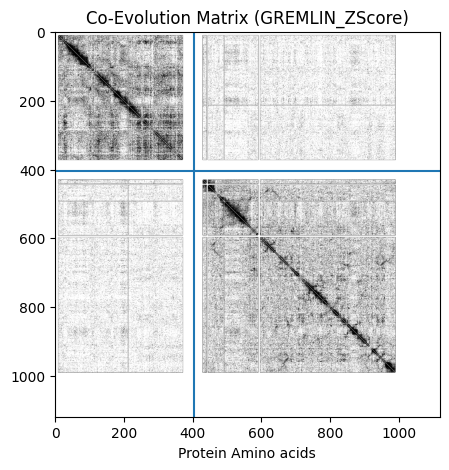

In [ ]:
query_sequence = sequence
mtx = get_mtx(mrf)
plot_mtx(mtx)

In [ ]:
######################################################################################
# WARNING - WARNING - WARNING
######################################################################################
# - the index starts at 0
# - the "first" position is 0
# - in bioinformatics, the first position of a sequence is often "1"
#   for this index use i_aa and j_aa!

# adding amino acid to index+1 this is done again in the next step #message from Chris LB Graham
seq = seqs[0]
mtx["i_aa"] = [f"{seq[i]}_{i+1}" for i in mtx["i"]]
mtx["j_aa"] = [f"{seq[j]}_{j+1}" for j in mtx["j"]]

# load mtx into pandas dataframe
pd_mtx = pd.DataFrame(mtx,columns=["i","j","raw","apc","zscore","i_aa","j_aa"])
coev_mtx = pd.DataFrame(mtx,columns=["i","j","zscore"])

In [ ]:
#@title Gremlin table, above threshold
# @markdown Please set the threshold to visualise in 3D and display in table form here. Please note that the residues above this threshold will be kept in the 'sorted_values.csv' A threshold of 2.5-3 or more is recommended, based on a limited dataset of available models currently.
import numpy as np
from numpy import load
import pandas as pd
GREM_threshold = 1.5 #@param
# Assuming pd_mtx is your DataFrame
# Extracting columns i, j, and apc into a new DataFrame
seq1 =len(query_sequence.split(':')[0])
if ':' in query_sequence:
  new_df = pd_mtx[['i', 'j', 'zscore']].copy()
  df = new_df
  df.columns = ["A", "B", "Score"]
  df.to_csv('grem_file.csv', sep=' ', index=False)
  df = df[(df['A'] < seq1) & (df['B'] >= seq1) & (df['B'] - df['A'] > 5 ) & (df['Score'] > GREM_threshold)]
  df = df.sub([0,seq1,0])
  df = df.add([1,1,0])
  df = df.sort_values('Score',ascending=False)
  df = df.reset_index()
  del df['index']
  df.to_csv('sorted_file.csv', sep=' ', index=False)
  print(df)
else:
  new_df = pd_mtx[['i', 'j', 'zscore']].copy()
  df = new_df
  df.columns = ["A", "B", "Score"]
  df.to_csv('grem_file.csv', sep=' ', index=False)
  df = df[(df['Score'] > GREM_threshold)]
  df = df.add([1,1,0])
  df = df.sort_values('Score',ascending=False)
  df = df.reset_index()
  del df['index']
  df.to_csv('sorted_file.csv', sep=' ', index=False)
  print(df)

        A    B     Score
0     286   34  3.047961
1     290   30  2.927518
2     289   33  2.679249
3     329  508  2.591197
4     202  244  2.568143
...   ...  ...       ...
1310  276   83  1.500848
1311  135  569  1.500768
1312  340  145  1.500656
1313   32  112  1.500517
1314  102   99  1.500068

[1315 rows x 3 columns]


In [ ]:
!python -m pip install --upgrade pip
!pip install tr-rosetta-pytorch
!apt-get install pymol

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 MB 10.3 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=d9f0627d5e664ae57a5eb8b7050e8df5360ac2e3ed160584f8684339d7afd9d2
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  apbs apbs-data freeglut3 libapbs3 libevdev2 libglu1-mesa libgudev-1.0-0 libinput-bin libinput10
  libmaloc1 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5 libqt5designer5 libqt5gui5 libqt5help5
  libqt5network5 libqt5opengl5 libqt5pr